<font size=7><br>Search Term Model Feature Engineering</font>

# Project Intro

This notebook represents a search term engagement model that was not incorporated in the final product. This notebook shows the cleaning process to createa a model predicting spike in search term engagement, based on previous searches in a particular demographic area. 

## Req'd Imports

In [39]:
import pandas as pd
from datetime import date

In [40]:
# Web scraped data from "web_scraping" notebook
show_details = pd.read_csv('data/ibdb_show_details.csv')
show_stops = pd.read_csv('data/idbd_show_stops.csv')

# Queried dataset from Open Broadway Data for all Broadway NYC shows since 2000
nyc_shows = pd.read_csv('data/open_broadway_data_shows_since_2003.csv')

# Tony Award winner data, scraped for Film-to-Broadway linear regression model 
tony_winners = pd.read_csv('data/tonys_tony_winners_list.csv')

# Transformation and Import New Data

### Convert NYC Shows opening/closing to datetime

In [3]:
opening_list = []
closing_list = []

for opening in nyc_shows.opening_date:
    try:
        opening = date.fromisoformat(opening)
        opening_list.append(opening)
    except:
        opening_list.append('N/A')

for closing in nyc_shows.closing_date:
    try:
        closing = date.fromisoformat(closing)
        closing_list.append(closing)
    except:
        closing_list.append('N/A')
        
nyc_shows.opening_date = opening_list
nyc_shows.closing_date = closing_list

### Clean Tonys Data Set

In [4]:
tony_winners = tony_winners.drop(columns='Unnamed: 0')

In [5]:
array = ['Revival (Play)', 'Play', 'Best Play', 'Musical', 'Revival', 'Revival (Musical)', 'Best Musical']
best_shows = tony_winners.loc[tony_winners['Award'].isin(array)]
best_shows = best_shows.reset_index(drop=True)
best_shows.to_csv('data/best_musicals_and_plays')

### Extract event_engagement and static_engagement features

#### Next step - extract target

In [6]:
df = pd.read_csv('data/scraped_data_no_duplicates.csv')

In [7]:
from project_functions import popularity_graph, closest_date, clean_show_title, column_to_datetime, engagement_table
from datetime import datetime as dt

In [8]:
df[df.geo_code == 'US-PA-508'].timestamp

1         2004-01-01 00:00:00
19        2004-01-01 00:00:00
77        2004-01-01 00:00:00
229       2004-01-01 00:00:00
291       2004-01-04 00:00:00
                 ...         
473980    2020-11-01 00:00:00
474056    2020-11-01 00:00:00
474128    2020-11-08 00:00:00
474305    2020-11-15 00:00:00
474362    2020-11-22 00:00:00
Name: timestamp, Length: 10106, dtype: object

In [9]:
df = df[df.search_term != 'dreamgirls (tour)']
df = df[df.search_term != 'big river (tour)']
df = df[df.search_term != 'i am my own wife (tour)']
df = df[df.search_term != 'little shop of horrors (tour)']
df = df[df.search_term != 'my fair lady (tour)']
#df = df[df.search_term != 'mary poppins (tour)' and df.geo_code=='US-CO-751']

df.to_csv('data/WORKING_scrape_1128.csv')

# VALUES NEEDED

<b>search_term</b>
<br>
<b>geo_code</b>
    
<b>nyc_opening_engagement feature</b> - engagement in time period of actual opening
<li>find closest_date to merged_stops_data.opening_date_nyc</li>
    
<b>event_engagement feature</b> - engagement on three months of either side of nyc opening

<li>find closest_date to merged_stops_data.opening_date_nyc</li>
<li>find the average frequencies on the surrounding three months of that date</li>

<b>static_engagement feature</b> - engagement between events - nyc opening and tour visiting town
<li>find range of dates from previous three month ending to tour_venue_opening</li>
    
<b>TARGET - in_town_engagement feature</b> - engagement when show is in town
<li>frequency when show is in town</li>

## Finding specific show assets (combined into engagement_table function)

In [10]:
show = 'a bronx tale (tour)'
geo_code = 'US-PA-504'

# necessary imports
merged_stops_data = pd.read_csv('data/merged_stops_data.csv')
list_of_cities = pd.read_csv('data/list_of_cities.csv')
df = pd.read_csv('data/final_raw_search_term_scrape.csv')


# if necessary, clean show title
entered_show_title = show
show = show.lower()
no_parentheses_show=0

if show[-1:] == ')':
    show.split('(')[0].strip()
else:
    no_parentheses_show = show
    
# set dataframe of interest
df_over_time = df[df.search_term == show][df.geo_code == geo_code].reset_index(drop=True)
df_over_time = df_over_time.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 'Unnamed: 0.1.1.1.1'])

# set df_over_time to shorter timestamp for later processing
df_over_time.timestamp = [x[:10] for x in df_over_time.timestamp]



<ipython-input-10-7320fd608b83>:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_over_time = df[df.search_term == show][df.geo_code == geo_code].reset_index(drop=True)


In [11]:
# SET SEARCH_TERM categorical variable
search_term = show


# SET GEO_CODE categorical variable
geo_code = geo_code

In [12]:
show

'a bronx tale (tour)'

In [13]:
# find nyc_opening_engagement feature
df_showstop = merged_stops_data[merged_stops_data['title'] == no_parentheses_show][merged_stops_data['full_code'] == geo_code]
if len(df_showstop) == 0:
    df_showstop = merged_stops_data[merged_stops_data['tour_descript'] == show][merged_stops_data['full_code'] == geo_code]
#show_title = df_showstop.title.iloc[0]
#full_title = df_showstop.tour_descript.iloc[0]
#tour_opening = df_showstop.tour_opening.iloc[0][:10]
nyc_opening = df_showstop.opening_date_nyc.iloc[0]

if type(df_over_time.timestamp[0]) == str:
    df_over_time.timestamp = column_to_datetime(df_over_time.timestamp)
    
if df_over_time.timestamp[0] > dt.strptime(nyc_opening, '%Y-%m-%d'):
    nyc_opening = dt.strftime(df_over_time.timestamp[0], '%Y-%m-%d')
        
    
nyc_opening_closest = closest_date(nyc_opening, df_over_time)


# SET NYC_OPENING_CLOSEST
nyc_opening_engagement = df_over_time[df_over_time['timestamp'] == nyc_opening_closest].frequency.iloc[0]

<ipython-input-13-3c55470736c6>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_showstop = merged_stops_data[merged_stops_data['title'] == no_parentheses_show][merged_stops_data['full_code'] == geo_code]
<ipython-input-13-3c55470736c6>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_showstop = merged_stops_data[merged_stops_data['tour_descript'] == show][merged_stops_data['full_code'] == geo_code]


In [14]:
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

date_dt = dt.strptime(nyc_opening, '%Y-%m-%d')

if df_over_time.timestamp[0] > date_dt:
    date_dt = df_over_time.timestamp[0]
    
three_months_before = dt.strftime(date_dt - relativedelta(months=3), '%Y-%m-%d')
three_months_after = dt.strftime(date_dt + relativedelta(months=3), '%Y-%m-%d')
before_closest = closest_date(three_months_before, df_over_time)
after_closest = closest_date(three_months_after, df_over_time)

before_index = df_over_time[df_over_time.timestamp == before_closest].index[0]
after_index = df_over_time[df_over_time.timestamp == after_closest].index[0]


# SET EVENT_ENGAGEMENT
if before_index != after_index:
    event_engagement = df_over_time[before_index:after_index].frequency.mean()
else:
    event_engagement = df_over_time[before_index].frequency

In [15]:
tour_venue_opening = df_showstop.city_opening_date.iloc[0][:10]
tour_venue_opening_closest = closest_date(tour_venue_opening, df_over_time)
tour_venue_open_index = df_over_time[df_over_time.timestamp == tour_venue_opening_closest].index[0]


# SET STATIC_ENGAGEMENT
if tour_venue_open_index != after_index:
    static_engagement = df_over_time[after_index:tour_venue_open_index].frequency.mean()
else:
    static_engagement = df_over_time.iloc[tour_venue_open_index.frequency]

In [16]:
tour_venue_closing = df_showstop.city_closing_date.iloc[0][:10]
tour_venue_closing_closest = closest_date(tour_venue_closing, df_over_time)
tour_venue_close_index = df_over_time[df_over_time.timestamp == tour_venue_closing_closest].index[0]


# SET IN_TOWN_ENGAGEMENT
if tour_venue_open_index != tour_venue_close_index:
    in_town_engagement = df_over_time[tour_venue_open_index:tour_venue_close_index].frequency.mean()
else:
    in_town_engagement = df_over_time.iloc[tour_venue_open_index].frequency

In [17]:
row_for_df = pd.DataFrame([[search_term, geo_code, nyc_opening_engagement, event_engagement, 
                            static_engagement, in_town_engagement]])

row_for_df.columns = [['search_term', 'geo_code', 'nyc_opening_engagement', 'event_engagement', 
                       'static_engagement', 'in_town_engagement']]

row_for_df

,search_term,geo_code,nyc_opening_engagement,event_engagement,static_engagement,in_town_engagement
0,a bronx tale (tour),US-PA-504,31,17.769231,13.658537,62.5


## Set list for full table transformation

<br><b>(see project_functions.py for full function description)</b><br><br>

In [18]:
# Create list of search terms and geo_code only 
full_list = df.groupby(['search_term', 'geo_code']).sum().index

In [19]:
# Create engagement table for 

full_engagement_table = engagement_table(full_list)

/Users/nickwilders/Desktop/METIS/metis_classwork/project5/project_functions.py:293: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_over_time = df[df.search_term == show][df.geo_code == geo_code].reset_index(drop=True)
/Users/nickwilders/Desktop/METIS/metis_classwork/project5/project_functions.py:311: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_showstop = merged_stops_data[merged_stops_data['title'] == no_parentheses_show][merged_stops_data['full_code'] == geo_code]
/Users/nickwilders/Desktop/METIS/metis_classwork/project5/project_functions.py:313: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_showstop = merged_stops_data[merged_stops_data['tour_descript'] == show][merged_stops_data['full_code'] == geo_code]



 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 0.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.


 Job is 1.0% complete.




 Job is 10.0% complete.


 Job is 10.0% complete.


 Job is 10.0% complete.


 Job is 10.0% complete.


 Job is 10.0% complete.


 Job is 10.0% complete.


 Job is 10.0% complete.


 Job is 10.0% complete.


 Job is 10.0% complete.


 Job is 10.0% complete.


 Job is 10.0% complete.


 Job is 10.0% complete.


 Job is 10.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.0% complete.


 Job is 11.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 20.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.0% complete.


 Job is 21.


 Job is 28.999999999999996% complete.


 Job is 28.999999999999996% complete.


 Job is 28.999999999999996% complete.


 Job is 28.999999999999996% complete.


 Job is 28.999999999999996% complete.


 Job is 28.999999999999996% complete.


 Job is 28.999999999999996% complete.


 Job is 28.999999999999996% complete.


 Job is 28.999999999999996% complete.


 Job is 28.999999999999996% complete.


 Job is 28.999999999999996% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0% complete.


 Job is 30.0%


 Job is 39.0% complete.


 Job is 39.0% complete.


 Job is 39.0% complete.


 Job is 39.0% complete.


 Job is 39.0% complete.


 Job is 39.0% complete.


 Job is 39.0% complete.


 Job is 39.0% complete.


 Job is 39.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.0% complete.


 Job is 40.


 Job is 49.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 50.0% complete.


 Job is 51.0% complete.


 Job is 51.0% complete.


 Job is 51.0% complete.


 Job is 51.0% complete.


 Job is 51.0% complete.


 Job is 51.0% complete.


 Job is 51.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 57.99999999999999% complete.


 Job is 59.0% complete.


 Job is 59.0% complete.


 Job is 59.0% complete.


 Job is 59.0% complete.


 Job is 59.0% complete.


 Job is 59.0% complete.


 Job is 59.0% complete.


 Job is 59.0% complete.


 Job is 59.0% complete.


 Job is 59.0% complete.


 Job is 59.0% complete.


 Job is 59.0% complete.


 Job is 59.0% complete.


 Job is 59.0% complete.


 Job is 59.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 68.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.0% complete.


 Job is 69.


 Job is 78.0% complete.


 Job is 78.0% complete.


 Job is 78.0% complete.


 Job is 78.0% complete.


 Job is 78.0% complete.


 Job is 78.0% complete.


 Job is 78.0% complete.


 Job is 78.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.0% complete.


 Job is 79.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 89.0% complete.


 Job is 90.0% complete.


 Job is 90.0% complete.


 Job is 90.0% complete.


 Job is 90.0% complete.


 Job is 90.0% complete.


 Job is 90.0% complete.


 Job is 90.0% complete.


 Job is 90.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 99.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete.


 Job is 100.0% complete

In [37]:
# Save table of all search term values in each city 

full_engagement_table_2 = full_engagement_table

In [38]:
# Change values that can be numeric to integers

full_engagement_table_2[['nyc_opening_engagement', 'event_engagement',
                                                 'static_engagement', 'static_engagement_min', 
                                                 'static_engagement_max','tour_open_engagement',
                                                 'in_town_engagement']] = full_engagement_table_2[['nyc_opening_engagement', 'event_engagement',
                                                 'static_engagement', 'static_engagement_min', 
                                                 'static_engagement_max','tour_open_engagement',
                                                 'in_town_engagement']].apply(pd.to_numeric, errors='coerce')

full_engagement_table_2.reset_index(drop=True, inplace=True)

# remove "merge error" values
full_engagement_table_2 = full_engagement_table_2[full_engagement_table_2.static_hits_zero!='merge error']

# change static_hits_zero to numbered value (instead of Boolean)
full_engagement_table_2['static_hits_zero'].replace({True:1, False:0}, inplace=True)

In [41]:
full_engagement_table_2.to_csv('data/full_engagement_table_3.csv')

## Further EDA / Feature Engineering

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

full_engagement_table = pd.read_csv('data/full_engagement_table_3.csv')

In [8]:
# Remove scrape errors where a value was recorded as infinity 

full_engagement_table = full_engagement_table[full_engagement_table['static_engagement_min'] != np.inf]

''

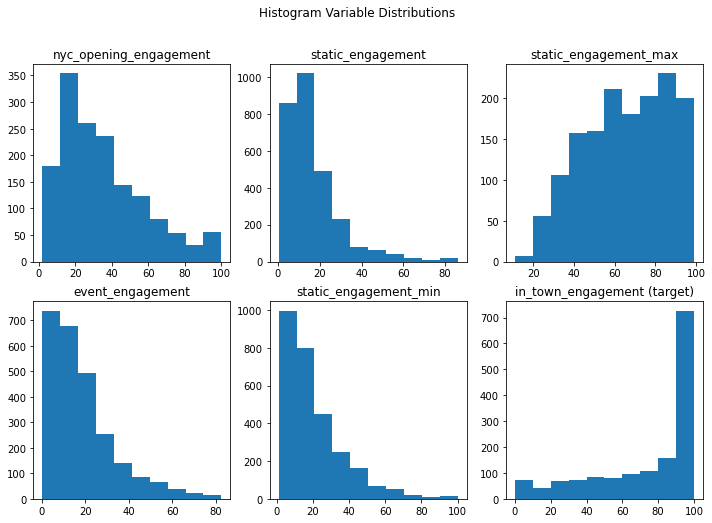

In [45]:
fig,axs = plt.subplots(2, 3, figsize=(12,8))
fig.suptitle('Histogram Variable Distributions')

axs[0,0].hist(full_engagement_table['nyc_opening_engagement'][full_engagement_table['nyc_opening_engagement'] > 0])
axs[0,0].set_title('nyc_opening_engagement')

axs[1,0].hist(full_engagement_table['event_engagement'][full_engagement_table['event_engagement'] > 0])
axs[1,0].set_title('event_engagement')

axs[0,1].hist(full_engagement_table['static_engagement'])
axs[0,1].set_title('static_engagement')

axs[1,1].hist(full_engagement_table['static_engagement_min'][full_engagement_table['static_engagement_min'] > 0])
axs[1,1].set_title('static_engagement_min')

axs[0,2].hist(full_engagement_table['static_engagement_max'][full_engagement_table['static_engagement_max'] < 100])
axs[0,2].set_title('static_engagement_max')

axs[1,2].hist(full_engagement_table['in_town_engagement'][full_engagement_table['static_engagement_max'] < 100])
axs[1,2].set_title('in_town_engagement (target)')



;

# Searches since 2015 - "shows near me" and "theatre near me"

This table represents relative search frequency of a term to all searched terms in that geographic area for "shows near me" and "theatre near me"

In [10]:
searches_since_2015 = pd.read_csv('data/searches_since_2015.csv')
searches_since_2015

,Unnamed: 0,geo_code,theatre_near_me,shows_near_me
0,0,Denver CO,85%,15%
1,1,Colorado Springs-Pueblo CO,82%,18%
2,2,Youngstown OH,NaN,100%
3,3,Panama City FL,59%,41%
4,4,South Bend-Elkhart IN,NaN,100%
...,...,...,...,...
205,205,Bend OR,NaN,NaN
206,206,Laredo TX,NaN,NaN
207,207,Greenwood-Greenville MS,NaN,NaN
208,208,Fairbanks AK,NaN,NaN


In [13]:
# Find amount of values where "Theatre Near Me" was such a small ratio that it was not even included
null_amount = round(searches_since_2015.theatre_near_me.isnull().value_counts()[1] / len(searches_since_2015),4)

print(null_amount*100, '% of theatre_near_me values are null, due to relatively low search term engagement (41% for shows_near_me)')

69.05 % of theatre_near_me values are null, due to relatively low search term engagement (41% for shows_near_me)


For this reason, let's look at the distribution of our known values to determine the most appropriate filled value. 

In [14]:
# drop all null values to find appropriate means
no_null = searches_since_2015.dropna()
no_null.theatre_near_me = [int(x[:-1]) for x in no_null['theatre_near_me']]
no_null.shows_near_me = [int(x[:-1]) for x in no_null['shows_near_me']]

/Users/nickwilders/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


''

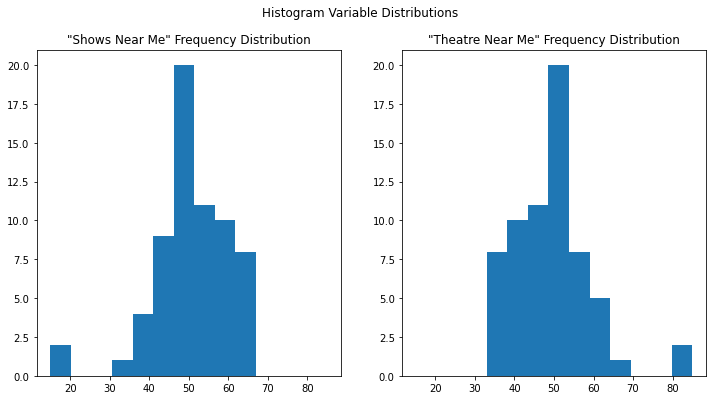

In [15]:
# Show histogram distribution of values

fig,axs = plt.subplots(1, 2, figsize=(12,6), sharex = True)
fig.suptitle('Histogram Variable Distributions')

axs[0].hist(no_null.shows_near_me)
axs[0].set_title('"Shows Near Me" Frequency Distribution')

axs[1].hist(no_null.theatre_near_me)
axs[1].set_title('"Theatre Near Me" Frequency Distribution')

;

<b><br>Both distributions of known values are <i>fairly</i> regular, so we will use the mean of unrepresented values - based on this data, we can assume set all nan values to 15, the average of the values that are too small to be represented by a number. </b><br><br>

In [16]:
# Fill all null values with 15% (see above)

searches_since_2015.fillna('15%', inplace=True)

# remove percentage and convert value to integer

searches_since_2015['theatre_near_me'] = [int(x[:-1]) for x in searches_since_2015['theatre_near_me']]
searches_since_2015['shows_near_me'] = [int(x[:-1]) for x in searches_since_2015['shows_near_me']]

In [68]:
searches_since_2015.columns=['Unnamed: 0', 'metro_area_name', 'theatre_near_me', 'shows_near_me']

## Add DMA Metro information

In [20]:
# Import Engagement Table from the search term engagement search
full_engagement_table_2 = pd.read_csv('data/full_engagement_table_3.csv')

# Importing US engagement specifically
us_engagement = pd.read_csv('data/us_engagement.csv')

# Importing List of Cities, dataframe found at 
list_of_cities = pd.read_csv('data/list_of_cities.csv')

In [22]:
list_of_cities

,Unnamed: 0,Unnamed: 0.1,city,geo_code,full_code,metro_area_name
0,0,0,"Houston, TX",618,US-TX-618,Houston TX
1,1,1,"Greenville, SC",567,US-SC-567,Greenville-Spartanburg SC-Asheville NC-Anderso...
2,2,2,"Oklahoma City, OK",650,US-OK-650,Oklahoma City OK
3,3,3,"St. Louis, MO",609,US-IL-609,St. Louis MO
4,4,4,"Salt Lake City, UT",770,US-NV-770,Salt Lake City UT
...,...,...,...,...,...,...
568,568,568,"Gloucester, VA",556,US-VA-556,Richmond-Petersburg VA
569,569,569,"Clarion, PA",508,US-PA-508,Pittsburgh PA
570,570,570,"Selinsburg, PA",566,US-PA-566,Harrisburg-Lancaster-Lebanon-York PA
571,571,571,"Greenwich, CT",CT,US-CT,Connecticut


In [26]:
# Create coorelated list of metros to their DMA code

metros = list_of_cities.groupby(['metro_area_name', 'full_code']).sum().reset_index()[['metro_area_name', 'full_code']]
metros.drop_duplicates(subset='full_code', inplace=True)
metros.columns=['metro_area_name', 'geo_code']

In [89]:
# Merge US Engagement to also include DmA 

us_engagement_with_metro = pd.merge(us_engagement, metros, on='geo_code', how='inner')

In [90]:
test = pd.merge(us_engagement_with_metro, searches_since_2015, on='metro_area_name', how='left')

test['theatre_near_me'] = test['theatre_near_me'].fillna(15)
test['shows_near_me'] = test['shows_near_me'].fillna(15)

test.to_csv('data/us_engagement_2_120220.csv')

# Appendix - Further EDA

In [27]:
engagement_no_max_min = full_engagement_table[full_engagement_table.nyc_opening_engagement < 100][full_engagement_table.nyc_opening_engagement > 0]


<ipython-input-27-8201abf617c7>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  engagement_no_max_min = full_engagement_table[full_engagement_table.nyc_opening_engagement < 100][full_engagement_table.nyc_opening_engagement > 0]


In [28]:
engagement_no_max_min.geo_code = engagement_no_max_min.geo_code.astype(str)

In [30]:
engagement_no_max_min.static_engagement.fillna(engagement_no_max_min.static_engagement.mean(),inplace=True)

In [31]:
engagement_no_max_min.static_engagement.mean()

22.35967490581334

In [32]:
engagement_no_max_min.event_engagement = engagement_no_max_min.event_engagement.astype('int64')
engagement_no_max_min.nyc_opening_engagement = engagement_no_max_min.nyc_opening_engagement.astype('int64')
engagement_no_max_min.static_engagement = engagement_no_max_min.static_engagement.astype('int64')
engagement_no_max_min.in_town_engagement = engagement_no_max_min.in_town_engagement.astype('int64')

In [33]:
engagement_no_max_min['state'] = [x[3:5] for x in engagement_no_max_min.geo_code]

In [34]:
state_regions = pd.read_csv('data/state_regions.csv')

In [35]:
state_regions.columns = ['full_state', 'state', 'region', 'division']

In [36]:
len(engagement_no_max_min)

1485

In [170]:
us_engagement = pd.merge(engagement_no_max_min, state_regions, on='state', how='inner')

In [175]:
engagement_no_max_min.to_csv('data/engagement_no_max_min.csv')

<AxesSubplot:xlabel='static_engagement', ylabel='in_town_engagement'>

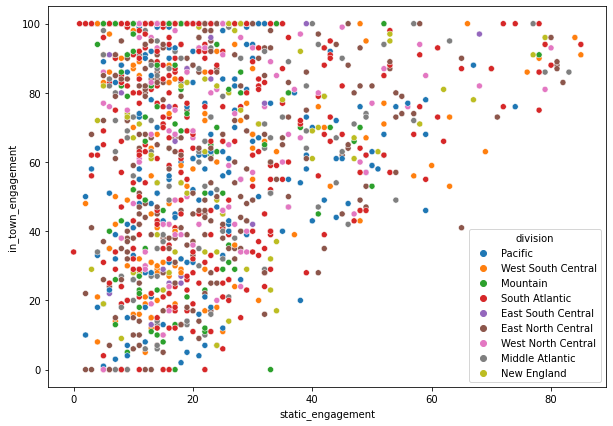

In [173]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x = us_engagement.static_engagement, y = us_engagement.in_town_engagement, 
                hue = us_engagement.division)


In [113]:
sns.plot(data = engagement_no_max_min, x = static_engagement, y= in_town_engagement)

AttributeError: module 'seaborn' has no attribute 'plot'

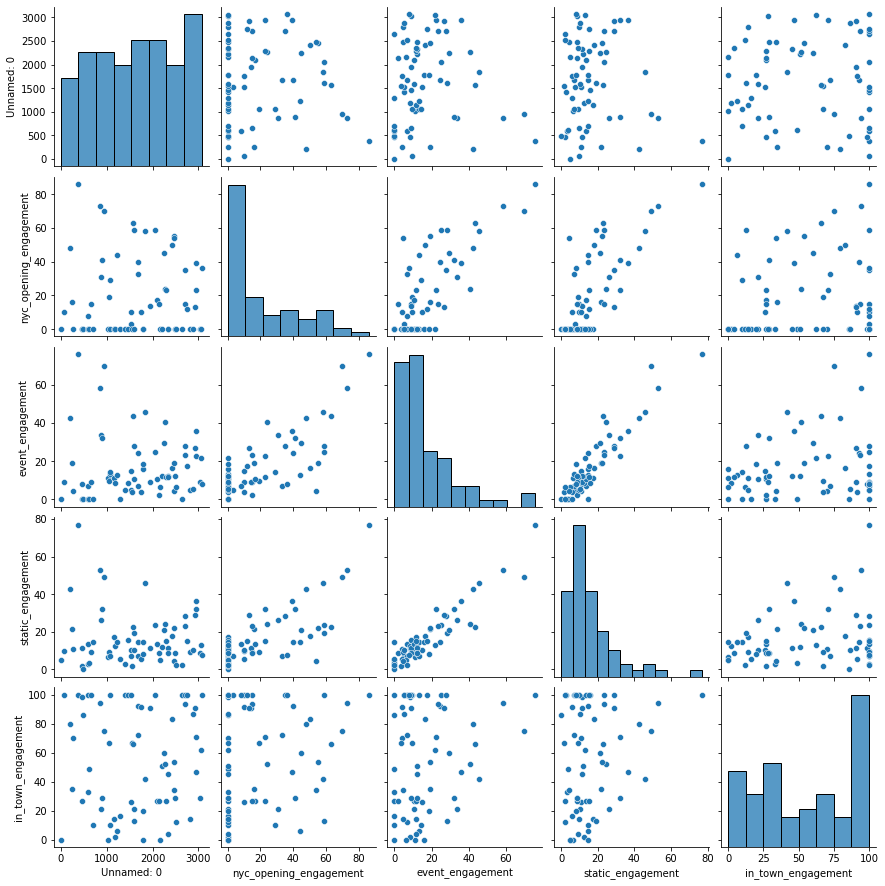

In [75]:
sns.pairplot(full_engagement_table[full_engagement_table.geo_code == 'US-PA-508'])

## 11/3 Work - Add Tonys feature

This section is intended to set a binary variable indicating if the show won a Tony for Best Musical or Best Play

In [190]:
import pandas as pd 
df = pd.read_csv('data/us_engagement_2_120220.csv')
tonys = pd.read_csv('data/best_musicals_and_plays.csv')

In [191]:
tonys.columns=['Unnamed: 0', 'year', 'award', 'title']

# lowercase all titles for easy of merge
tonys['title'] = tonys.title.str.lower()

In [192]:
# add column without (tour)
df['title'] = [x.split(' (')[0] for x in df.search_term]

In [195]:
# if value is in the list of Tony Award-winning plays and musicals, append with 1 (True) - 
# otherwise append with 0 (False)

tonys_list = []

for title in df.title:
    if title in tonys['title'].unique():
        tonys_list.append(1)
    else:
        tonys_list.append(0)
        
df['tony_winner'] = tonys_list

In [197]:
# Save to send over to model development

df.to_csv('data/us_engagement_120320.csv')